In [1]:
import flopy
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as deepcopy

In [2]:
exe_name_mf = '../bin/mf2005.exe'; exe_name_mt = '../bin/mt3dusgs1.1.0/bin/mt3d-usgs_1.1.0_64.exe' 
model_ws    = '.';  dirname = '.'

In [3]:
def plot_2d(map_data, dx, dy, colorbar_label, cmap):                                                             # FUNCTION_01
    r, c   = np.shape   (map_data);                 x_coord = np.linspace(0, dx*c, c+1);  y_coord = np.linspace(0, dy*r, r+1);  
    X,Y    = np.meshgrid(x_coord, y_coord)
    plt.figure(figsize=(3, 1), dpi=150)
    plt.pcolormesh(X, Y, map_data, cmap=cmap,    shading = 'auto', edgecolor ='k', linewidth = 0.001)
    plt.gca().set_aspect('equal');                  cbar = plt.colorbar();         cbar.set_label(colorbar_label)
    plt.tick_params(axis='both', which='major');    plt.xlim((0, dx*c));           plt.ylim((0, dy*r)) ; plt.show()

In [4]:
def model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol):     # FUNCTION_02
    itmuni = 4; mt_tunit = 'D';   lenuni = 2; mt_lunit = 'M'     # Days | Meters
    nper = len(perlen_mf);        nprs = 100 ;                   timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    hk = 1 ; prsity = 0.3 ;       delv = 1 ; delc = 1 ; delr = 1 
    
    modelname_mf = 'mf06_mf'
    mf     = flopy.modflow.Modflow(modelname    = modelname_mf,      model_ws = model_ws,  exe_name   = exe_name_mf)
    dis    = flopy.modflow.ModflowDis(mf, nlay  = nlay, nrow = nrow, ncol=ncol,  nper = nper, delr    = delr, delc=delc, 
                                   top=0., botm =[0 - delv], perlen=perlen_mf, itmuni =itmuni, lenuni = lenuni)
    bas    = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    laytyp = 0
    lpf    = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    wel    = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    pcg    = flopy.modflow.ModflowPcg(mf)
    lmt    = flopy.modflow.ModflowLmt(mf)
    oc     =  flopy.modflow.ModflowOc(mf)
    mf.write_input() ;             mf.run_model(silent=True)         # ____________________________ write | run __mf
    
    modelname_mt = 'mt_____06_mt'
    mt     = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
    btn    = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nprs=nprs, timprs=timprs)
    mixelm = -1
    adv    = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=0.5)
    dsp    = flopy.mt3d.Mt3dDsp(mt, al=al)
    ssm    = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg    = flopy.mt3d.Mt3dGcg(mt, cclose=1e-6)
    mt.write_input();              mt.run_model(silent=True)         # ____________________________ write | run __mt

    fname   = os.path.join(model_ws, 'mf06_mf'+'.hds')   # heads (103, 1, 20, 40)
    hdobj   = flopy.utils.HeadFile(fname)
    heads   = hdobj.get_data();                       Ar = heads.reshape(heads.shape[0], -1);  Ar2 = pd.DataFrame(Ar);      Ar2.to_csv ("06a1_H(x).csv")
    fname   = os.path.join(model_ws, 'MT3D001.UCN');
    ucnobj  = flopy.utils.UcnFile(fname);    
    conc = ucnobj.get_alldata();                      Cr = conc.reshape(conc.shape[0],  -1);   Cr2 = pd.DataFrame(Cr);      Cr2.to_csv ("06b1_C(x).csv") 
    times  = np.array(ucnobj.get_times());           
    return mf, mt, times, conc;                       # Binaries                           

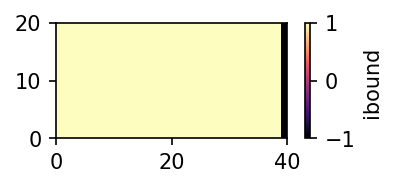

(1, 20, 40)


In [5]:
nlay = 1;   nrow = 20; ncol = 40
strt             = np.zeros((nlay, nrow, ncol), dtype=float)          
ibound           = np.ones ((nlay, nrow, ncol), dtype=int)
ibound[0, :, -1] = -1;      plot_2d(ibound[0,:,:], 1, 1, 'ibound ', 'magma');         print(ibound.shape); # [0,:,:]

In [6]:
strt = np.zeros((nlay, nrow, ncol), dtype=float)        ; q = [0.5, 0.5, -0.5] # ...  spd_mf = {0:[[0, 0, 1, q],[0, 5, 1, q]]}
well_info       = np.zeros((int(nrow), 4), dtype=float)        # define well info structure
well_info[:,1]  = range(0, nrow)                               # set indices of left face [:,1] = range(0, nrow)   # set volumetric flow [:,3] = q[0]  
well_info[:,3]  = q[0];       w = deepcopy(well_info);                   spd_mf        = {0 : w}         
well_info[:,3]  = q[1];       w = deepcopy(well_info);                   spd_mf.update ( {1 : w} )       # Second stress period
well_info[:,3]  = q[2];       w = deepcopy(well_info);                   spd_mf.update ( {2 : w} )       # Third  stress period 

icbund          = np.ones  ((nlay, nrow, ncol), dtype=int)                                               # active concentration cells      
sconc           = np.zeros ((nlay, nrow, ncol), dtype=float);             c = [1, 0, 0]; itype = -1      # initial concentrations  # C at 1º S. Period
cwell_info      = np.zeros ((  int(nrow),   5), dtype=float)                           # itype = -1 (cst conc), 2=well, 3=drain 

cwell_info[:,1] = range(0, nrow)
cwell_info[:,3] = c[0]            # set conc. [:,3] = c[0] at position [:,1], ... range 1,2,3,..20
cwell_info[:,4] = itype;                                                 spd_mt =      {0:cwell_info };    
cwell_info2     = deepcopy(cwell_info);     cwell_info2[:,3] = c[1];     spd_mt.update({1:cwell_info2})  # Second stress period
cwell_info2     = deepcopy(cwell_info);     cwell_info2[:,3] = c[2];     spd_mt.update({2:cwell_info2})  # Third  stress period

w0 = well_info[:,3];     Ar1 = pd.DataFrame(w0);   Ar1.to_csv ("01.csv")
z0 = range(0, nrow);     Ar1 = pd.DataFrame(z0);   Ar1.to_csv ("00.csv")
Ar1 = pd.DataFrame(cwell_info);        Ar1.to_csv ("06_cwell_info1.csv")
Ar2 = pd.DataFrame(cwell_info2);       Ar2.to_csv ("06_cwell_info2.csv")      # Ar3 = pd.DataFrame(spd_mt);  Ar3.to_csv ("06_cwell_info2.csv")

# **spd_mf spd_mt** `sources sincks sensitive`

[ 1 19 29]


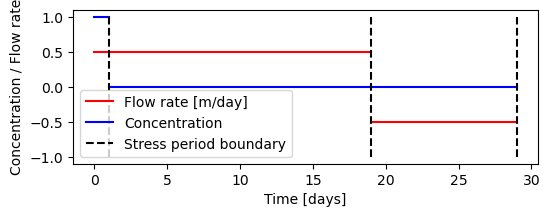

In [7]:
perlen_mf                    = [1, 18, 10];             nper = len(perlen_mf)                        # Strees periods
model_time = np.cumsum(perlen_mf); print(model_time);   plt.figure(figsize=(6,2))
plt.plot( [0,            model_time[0]],  [q[0],  q[0] ], color='r',  label= 'Flow rate [m/day]')
plt.plot( [model_time[0],model_time[1]],  [q[1],  q[1] ], color='r') 
plt.plot( [model_time[1],model_time[2]],  [q[2],  q[2] ], color='r')

plt.plot( [0,            model_time[0]],  [c[0],  c[0] ], color='b',  label= 'Concentration')
plt.plot( [model_time[0],model_time[1]],  [c[1],  c[1] ], color='b') 
plt.plot( [model_time[1],model_time[2]],  [c[2],  c[2] ], color='b')

plt.plot( [model_time[0],model_time[0]],  [-1, 1],   '--k',  label= 'Stress period boundary')
plt.plot( [model_time[1],model_time[1]],  [-1, 1],   '--k') 
plt.plot( [model_time[2],model_time[2]],  [-1, 1],   '--k'); plt.xlabel('Time [days]'); plt.ylabel('Concentration / Flow rate');plt.legend();plt.show()

In [8]:
D = pd.DataFrame(model_time); D.to_csv("06a(Time)_y.csv")

In [9]:
dirname = 'run1';   al = 0.1  # meters            # RUN FUNCTION
mf, mt, times, conc = model_with_wells(dirname, perlen_mf, al, ibound, strt, icbund, sconc, spd_mf, spd_mt, nlay, nrow, ncol)  

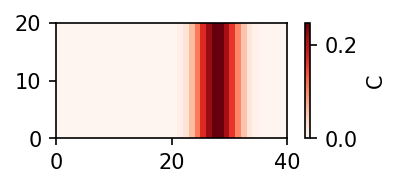

In [10]:
#plot_2d(conc [1,  0,:,:], 1, 1, 'C', 'Reds')        # early time
plot_2d(conc [58, 0,:,:], 1, 1, 'C', 'Reds')        # around the switch in flow (stress period 1 - 2 boundary)
#plot_2d(conc [-1, 0,:,:], 1, 1, 'C', 'Reds')        # last time step

In [11]:
# print(heads.shape)  
print(conc.shape) 

(103, 1, 20, 40)


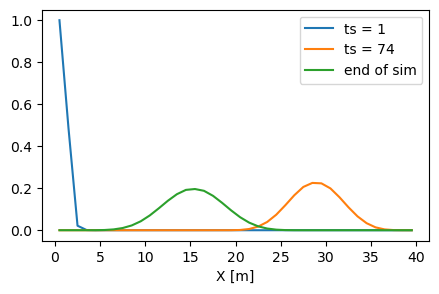

In [12]:
ym, xm, zm = mf.dis.get_node_coordinates();                        Cr = pd.DataFrame(xm); Cr.to_csv("06d1_x.csv") 
plt.figure(figsize=(5,3));                                         Dr = pd.DataFrame(ym); Dr.to_csv("06d2_y.csv")
plt.plot(xm, np.mean(conc[1,  0, :, :], axis=0), label='ts = 1')
plt.plot(xm, np.mean(conc[74, 0, :, :], axis=0), label='ts = 74')          # mean ? _(X)_____________________________________    
plt.plot(xm, np.mean(conc[-1, 0, :, :], axis=0), label='end of sim');      plt.xlabel('X [m]'); plt.legend() ; plt.show()

In [13]:
iB = ibound[0,:,:];  cr = pd.DataFrame(iB);     cr.to_csv ("06f(ibound).csv");    print(cr.shape),  # c    # [0, :20, 39]

(20, 40)


(None,)

In [14]:
fname   = os.path.join(model_ws, 'mf06_mf'+'.hds')   
hdobj   = flopy.utils.HeadFile(fname)
heads   = hdobj.get_data();               print(heads.shape)  

(1, 20, 40)


In [15]:
ir2 = heads[0,:,:];   cr = pd.DataFrame(ir2);     cr.to_csv ("06g(heads).csv");    print(cr.shape),  # c    # [0, :20, 39]

(20, 40)


(None,)

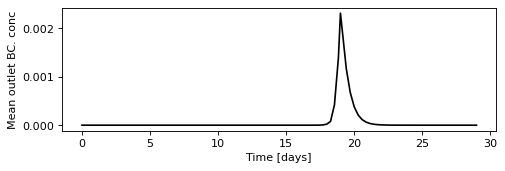

In [16]:
C_btc_model = np.mean([conc[:, 0, :, -1]], axis=2)
plt.figure(figsize=(7, 2), dpi=80) ; plt.plot(times, np.transpose(C_btc_model), 'k', label='')
plt.xlabel('Time [days]'); plt.ylabel('Mean outlet BC. conc'); plt.show()

In [17]:
print(conc.shape)   # print(C_btc_model.shape) = (1,103)

(103, 1, 20, 40)


In [18]:
print(C_btc_model.shape)

(1, 103)


In [19]:
bt = np.transpose(C_btc_model);           cr = pd.DataFrame(bt);              cr.to_csv ("C_btc.csv")
a = np.array([[1, 2], [3, 4], [5, 6]]);   cr = pd.DataFrame(a);               cr.to_csv ("a1.csv")
b = np.mean(a, axis=1) ;                  cr = pd.DataFrame(b);               cr.to_csv ("a2.csv");    # b 

In [21]:
np.mean(iB, axis=1)

array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95,
       0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95])

In [22]:
a2D = np.array( [ [ 1, 2, 3, 4,  5 ] ,
                  [ 6, 7, 8, 9, 10 ] ] )                        ; print(a2D.shape);   a2D 

(2, 5)


array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [24]:
a3D = np.array( [ [ [ 1,2,1,1,1]    , [ 3, 4,1,1,1]  ],
                    [ [5,6,1,1,1]   , [ 7, 8,1,1,1]  ],
                    [ [13,14,1,1,1] , [16,17,1,1,1]  ] ]);       print(a3D.shape);    a3D

(3, 2, 5)


array([[[ 1,  2,  1,  1,  1],
        [ 3,  4,  1,  1,  1]],

       [[ 5,  6,  1,  1,  1],
        [ 7,  8,  1,  1,  1]],

       [[13, 14,  1,  1,  1],
        [16, 17,  1,  1,  1]]])

In [65]:
a4D = np.array([ [  [ [1, 2, 1,1,-1] ,[ 3, 4,1,1,-1] ,[ 5, 6,1,1,-1] ]  ],         # 2D = array of vectors (rows or columns)   (2 x 4), ... (10, 3)
                 [  [ [7, 8, 1,1,-1] ,[ 9,10,1,1,-1] ,[11,12,1,1,-1] ]  ],         # 3D = array of 2D array 
                 [  [ [13,14,1,1,-1] ,[15,16,1,1,-1] ,[17,18,1,1,-1] ]  ] ])       # 4D = array of 3D arrays 
print(a4D.shape)
a4D 

(3, 1, 3, 5)


array([[[[ 1,  2,  1,  1, -1],
         [ 3,  4,  1,  1, -1],
         [ 5,  6,  1,  1, -1]]],


       [[[ 7,  8,  1,  1, -1],
         [ 9, 10,  1,  1, -1],
         [11, 12,  1,  1, -1]]],


       [[[13, 14,  1,  1, -1],
         [15, 16,  1,  1, -1],
         [17, 18,  1,  1, -1]]]])

In [69]:
ab1 = a4D[:, 0, :, -1];       print(ab1.shape);    cr = pd.DataFrame(ab1);        cr.to_csv ("ab1.csv"); ab1   

(3, 3)


array([[-1, -1, -1],
       [-1, -1, -1],
       [-1, -1, -1]])

In [70]:
print(conc.shape) 

(103, 1, 20, 40)


In [72]:
 Cr = conc.reshape(conc.shape[0],  -1);   Cr2 = pd.DataFrame(Cr);      Cr2.to_csv ("06b1_C(x).csv") ; print(Cr2.shape)   # 20*40=800

(103, 800)


In [66]:
a4d = np.array([ [  [ [1,2]  ,[3,4]   ,[5,6]   ]  ],         # 2D = array of vectors (rows or columns)   (2 x 4), ... (10, 3)
                 [  [ [7,8]  ,[9,10]  ,[11,12] ]  ],         # 3D = array of 2D array 
                 [  [ [13,14],[15,16] ,[17,18] ]  ] ]) ; print(a4d.shape)  ; a4d 

(3, 1, 3, 2)


array([[[[ 1,  2],
         [ 3,  4],
         [ 5,  6]]],


       [[[ 7,  8],
         [ 9, 10],
         [11, 12]]],


       [[[13, 14],
         [15, 16],
         [17, 18]]]])

In [67]:
ab2 = a4d[:, 0, :, -1];        cr = pd.DataFrame(ab1);              cr.to_csv ("ab2.csv"); ab1   

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [40]:
ab3 = np.mean([a4d[:, 0, :, -1]], axis=2)  ;              print(ab3.shape) ;  ab3

(1, 3)


array([[ 4., 10., 16.]])

In [58]:
# ab3 = np.mean(ab1, axis=1)  ;                             print(ab3.shape) ;  ab3